In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/customers/Customers.csv")[:500]

df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


# Смотрим на данные

In [2]:
# drop customer id as it is unique

df = df.drop(["CustomerID"], axis=1)

df.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6


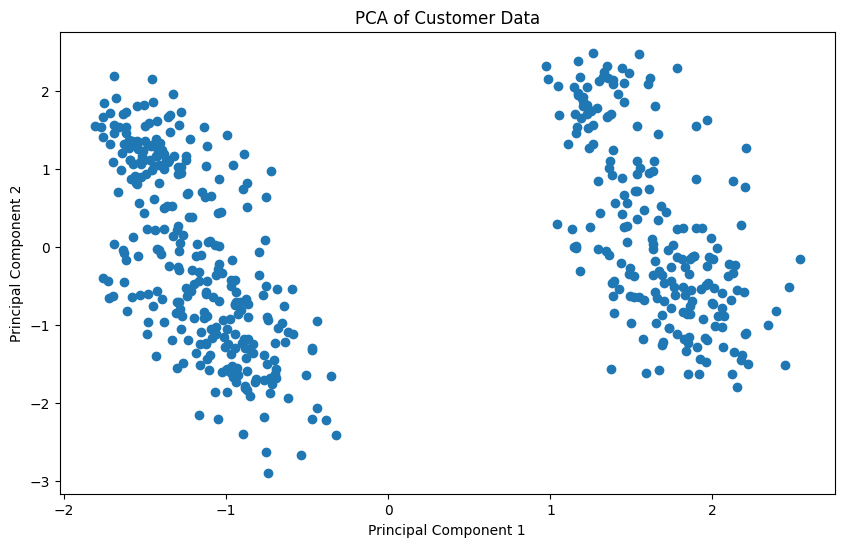

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df)

# Normalize numerical columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Customer Data")
plt.show()

In [4]:
from algorithms.hierarchical import hierarchy
from scipy.spatial.distance import cdist

distances = cdist(df_scaled, df_scaled)

distances.shape

(500, 500)

In [5]:
%%time
pairwise_distances, clusters_power, optimal_clusters = hierarchy(distances)

CPU times: user 155 ms, sys: 38.1 ms, total: 193 ms
Wall time: 191 ms


In [6]:
optimal_clusters

11

In [21]:
linkage_matrix = np.array([]).reshape((0, 4))
for k, v in pairwise_distances.items():
    row = np.array([k[0], k[1], v, clusters_power[k[0]] + clusters_power[k[1]]])
    linkage_matrix = np.vstack([linkage_matrix, row])

linkage_matrix.shape

(499, 4)

In [22]:
%%time
from scipy.cluster import hierarchy as hierarchy_lib

Z = hierarchy_lib.linkage(df_scaled, "ward")

CPU times: user 2.38 ms, sys: 1.06 ms, total: 3.44 ms
Wall time: 2.41 ms


Text(0.5, 1.0, 'Scipy Implementation')

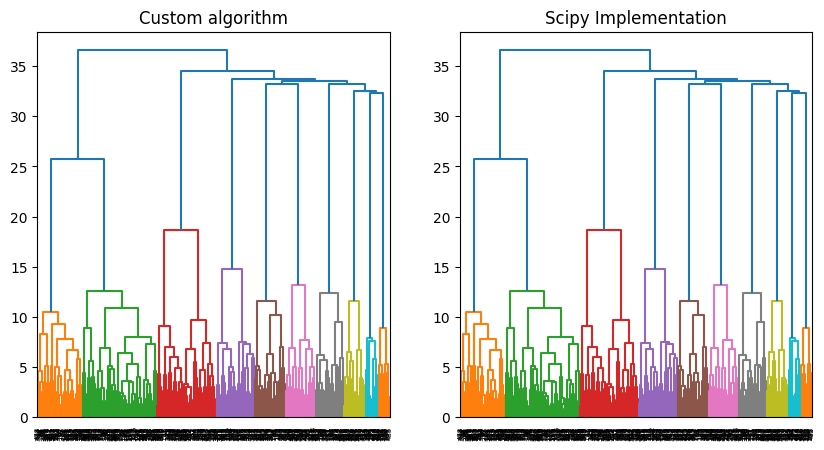

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dm0 = hierarchy_lib.dendrogram(linkage_matrix, ax=axes[0])
axes[0].set_title("Custom algorithm")

dm1 = hierarchy_lib.dendrogram(Z, ax=axes[1])
axes[1].set_title("Scipy Implementation")

In [24]:
import random
from algorithms.em import em_clustering

random.seed(0)

In [38]:
EM_MAX_STEP = 100

In [44]:
%%time
y = em_clustering(
    df_scaled,
    num_features=16,
    num_clusters=2,
    max_step=EM_MAX_STEP,
)
y.shape

CPU times: user 1.76 ms, sys: 1.71 ms, total: 3.47 ms
Wall time: 2.2 ms


/Users/alexanderivanov/programs/python/fall-24/students/ai-ivanov/lab1/source/algorithms/em.py:36: RuntimeWarning: divide by zero encountered in divide
  ro_sq = np.sum((objects[:, :] - centers[i]) ** 2 / sigmas[i], axis=1)
/Users/alexanderivanov/programs/python/fall-24/students/ai-ivanov/lab1/source/algorithms/em.py:36: RuntimeWarning: invalid value encountered in divide
  ro_sq = np.sum((objects[:, :] - centers[i]) ** 2 / sigmas[i], axis=1)
/Users/alexanderivanov/programs/python/fall-24/students/ai-ivanov/lab1/source/algorithms/em.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  np.power((2 * np.pi), -num_features / 2)
/Users/alexanderivanov/programs/python/fall-24/students/ai-ivanov/lab1/source/algorithms/em.py:38: RuntimeWarning: invalid value encountered in multiply
  np.power((2 * np.pi), -num_features / 2)


(500,)

In [43]:
%%time
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(
    n_components=2,
    max_iter=EM_MAX_STEP,
    covariance_type="diag",
).fit(df_scaled)
y_lib = gm.predict(df_scaled)

CPU times: user 5.73 ms, sys: 6.7 ms, total: 12.4 ms
Wall time: 3.17 ms


In [27]:
def plot_clusters(y, title):
    # Plot using PCA components we created earlier
    plt.figure(figsize=(5, 3))
    plt.scatter(pca_df["PC1"], pca_df["PC2"], c=y, cmap="viridis", edgecolors="k")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.colorbar(label="Cluster")
    plt.show()

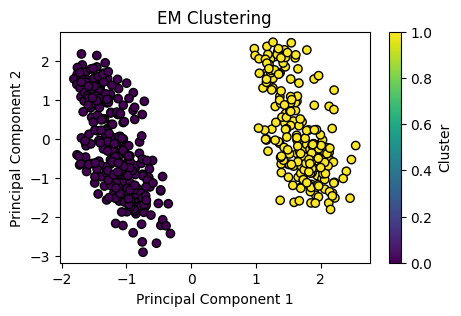

In [28]:
plot_clusters(y, "EM Clustering")

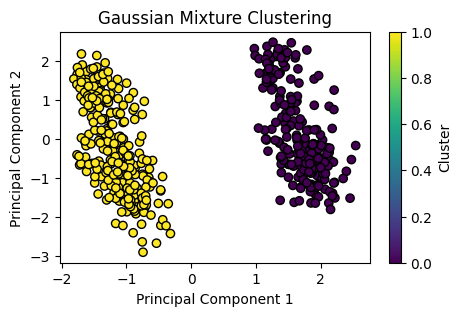

In [29]:
plot_clusters(y_lib, "Gaussian Mixture Clustering")

In [30]:
MIN_SAMPLES = 5
EPS = 3

In [31]:
%%time
from algorithms.dbscan import dbscan_clustering

roles, lbls = dbscan_clustering(
    df_scaled,
    epsilon=EPS,
    min_samples=MIN_SAMPLES,
)
lbls.shape

CPU times: user 27.2 ms, sys: 32.1 ms, total: 59.3 ms
Wall time: 9.19 ms


(500,)

In [32]:
%%time
from sklearn.cluster import DBSCAN

lbls_lib = DBSCAN(
    eps=EPS,
    min_samples=MIN_SAMPLES,
).fit_predict(df_scaled)

lbls_lib.shape

CPU times: user 6.06 ms, sys: 7.95 ms, total: 14 ms
Wall time: 2.94 ms


(500,)

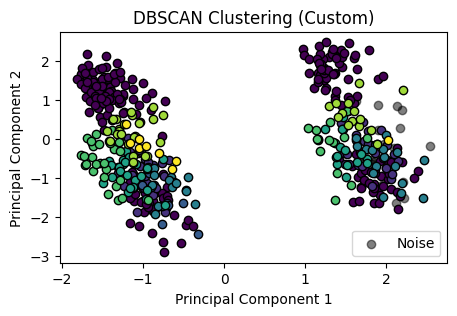

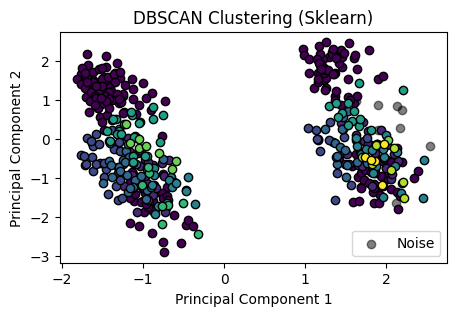

In [33]:
def plot_dbscan_clusters(y, title):
    plt.figure(figsize=(5, 3))

    # Create discrete colormap
    unique_clusters = np.unique(y[y != -1])  # Get unique cluster labels excluding noise
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

    # Plot noise points in black
    mask_noise = y == -1
    plt.scatter(
        pca_df["PC1"][mask_noise],
        pca_df["PC2"][mask_noise],
        c="black",
        label="Noise",
        alpha=0.5,
    )
    LIMIT = 10
    # Plot each cluster with a different color
    for idx, cluster_label in enumerate(unique_clusters[:LIMIT]):
        mask = y == cluster_label
        plt.scatter(
            pca_df["PC1"][mask], pca_df["PC2"][mask], c=[colors[idx]], edgecolors="k"
        )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.legend()
    plt.show()


plot_dbscan_clusters(lbls, "DBSCAN Clustering (Custom)")
plot_dbscan_clusters(lbls_lib, "DBSCAN Clustering (Sklearn)")